# Synthetic Movie Dataset Generation

In [1]:
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd

from abc import ABC, abstractmethod
from scipy.sparse import dok_matrix
from scipy.stats import skewnorm
from typing import Union, Tuple
from itertools import zip_longest

## Movies

In [2]:
no_movies = 5000
no_categories = 11

# how good (objectively) the movies are
objective_ratings = skewnorm.rvs(0.5, loc=0.6, scale=0.14, size=5000).clip(0, 1)
# movie categories
movie_to_category = np.random.randint(0, no_categories, size=no_movies)

## Users

In [3]:
class UserType():
    def __init__(self, name, number, prob, liked_unliked_category_distribution_param, is_category_excluded):
        self.name = name
        self.number = number
        self.param = np.array(liked_unliked_category_distribution_param)
        self.like_category_prob = np.array(prob)
        self.is_category_excluded = np.array(is_category_excluded)

    def generate_ratings(self):
        included_categories = np.where(self.is_category_excluded == False)[0]

        is_category_liked_by_users = np.full((self.number, no_categories), False)
        is_category_liked_by_users[:, included_categories] = np.random.binomial(
            1, 
            self.like_category_prob[included_categories], 
            size=(self.number, len(included_categories))
        )

        is_movie_included = np.in1d(movie_to_category, included_categories)
        categories_of_included_movies = movie_to_category[is_movie_included]

        is_included_movie_liked_by_user = is_category_liked_by_users[:, categories_of_included_movies].astype(int).flatten()

        params = self.param[is_included_movie_liked_by_user]
        modes = np.tile(objective_ratings[is_movie_included], self.number)

        ratings = np.zeros((self.number, no_movies))

        ratings[:, is_movie_included] = (
            modes + 
            params[:, 0] *
            (np.random.rayleigh(params[:, 1]) + params[:, 2])
        ).clip(0, 1).reshape(self.number, len(categories_of_included_movies))

        return ratings, is_category_liked_by_users

In [4]:
no_adults = 700
no_kids = 300

no_users = no_adults + no_kids

# 0 = not assigned, 1 = strangers, 2 = Acquaintances, 3 = close friends
# all kids are close friends so they are not represented here :)
relationships = dok_matrix((no_adults, no_adults), dtype=int)

user_types = {
    'adult': UserType('adult', no_adults, [0.6] * 6 + [0.3] * 3 + [0] * 2, [[-1, 0.15, 0.2], [1, 0.1, -0.1]], [False] * 9 + [True] * 2), 
    'kid': UserType('kid', no_kids, [0] * 6 + [0.4] * 3 + [0.7] * 2, [[-1, 0.2, 0.15], [1, 0.1, 0]], [True] * 6 + [False] * 5)
}

In [5]:
ratings = np.empty((0, no_movies), dtype=float)
liked_categories = np.empty((0, no_categories), dtype=bool)

for user_type in user_types.values():
    _ratings, _liked_categories = user_type.generate_ratings()

    ratings = np.concatenate((ratings, _ratings))
    liked_categories = np.concatenate((liked_categories, _liked_categories))

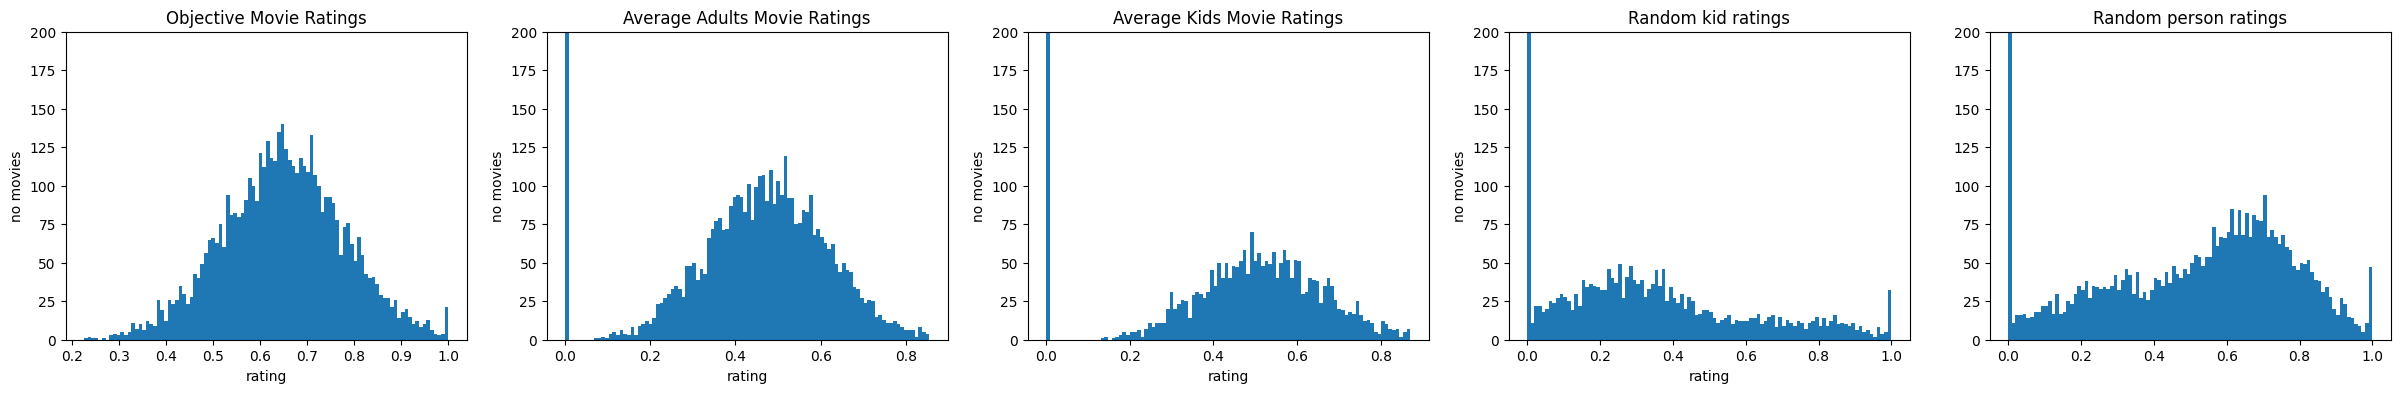

In [6]:
fig, axs = plt.subplots(ncols=5, figsize=(30, 4))
axs[0].hist(objective_ratings, bins = 100)
axs[0].set_title('Objective Movie Ratings')
axs[0].set_ylim(0, 200)

axs[1].hist(ratings[:no_adults].mean(axis=0), bins = 100)
axs[1].set_title('Average Adults Movie Ratings')
axs[1].set_ylim(0, 200)

axs[2].hist(ratings[no_adults:].mean(axis=0), bins = 100)
axs[2].set_title('Average Kids Movie Ratings')
axs[2].set_ylim(0, 200)

axs[3].hist(ratings[-1], bins = 100)
axs[3].set_title('Random kid ratings')
axs[3].set_ylim(0, 200)

axs[4].hist(ratings[0], bins = 100)
axs[4].set_title('Random person ratings')
axs[4].set_ylim(0, 200)

for i in range(4):
    axs[i].set_xlabel('rating')
    axs[i].set_ylabel('no movies')
plt.show()

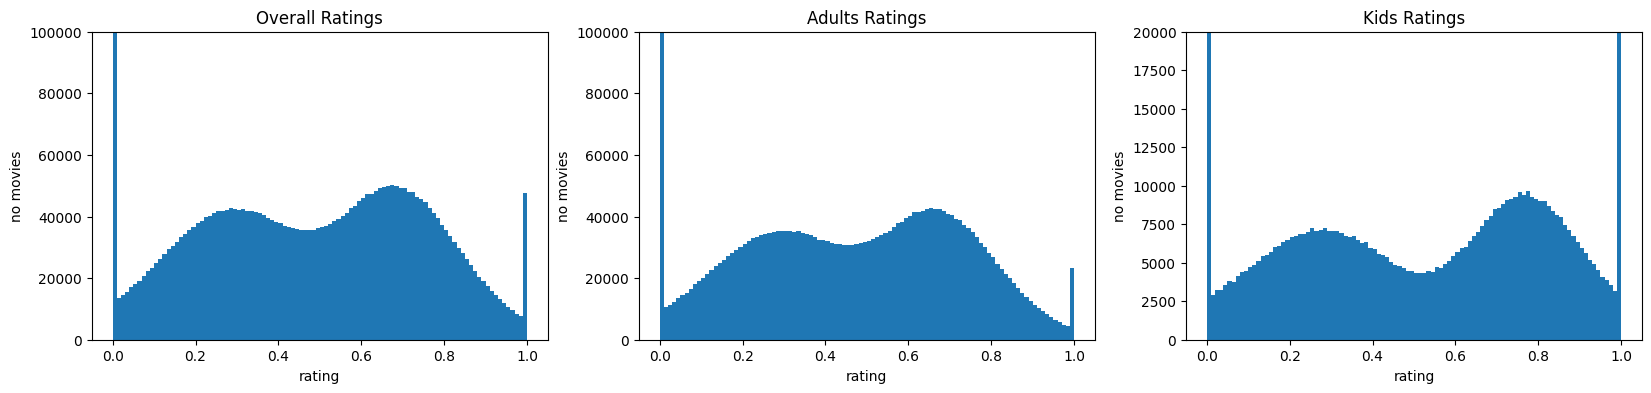

In [7]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 4))
axs[0].hist(ratings.flatten(), bins = 100)
axs[1].hist(ratings[:no_adults].flatten(), bins = 100)
axs[2].hist(ratings[no_adults:].flatten(), bins = 100)

axs[0].set_ylim(0, 100000)
axs[1].set_ylim(0, 100000)
axs[2].set_ylim(0, 20000)

axs[0].set_title('Overall Ratings')
axs[1].set_title('Adults Ratings')
axs[2].set_title('Kids Ratings')

for i in range(3):
    axs[i].set_xlabel('rating')
    axs[i].set_ylabel('no movies')
plt.show()

## Groups

Based in the paper (TODO: add paper), three different group types can be distinguished:

* **Friends / Families / Couples**: this group type will satisfy the user with the highest rating. The idea is that being close friends, they watch movies together often and will be satisfied in turns. They are also likely to be satisfied if another member is very happy.

* **Acquaintances**: this group type uses a smart average formula that takes into account the user expertiese and a bias towards satisfying kids. 

* **Strangers**: this group type is based on the idea that strangers are polite to each other hence they make sure no one is too disappointed. Only adults can be strangers since all kids are close friends. 

In [8]:
# + x% weight when using weights to do score aggregation
experts_bonus = 0.2
kids_bonus = 0.2

In [9]:
def choose_adults(no_adults_in_group, relation_requirement) -> np.ndarray:
    '''
    Randomly chooses @no_adults adult users such that the @relation_requirement holds among any two of them.
    '''

    adults = [] 
    for _ in range(no_adults_in_group):
        ok = False
        adult = None

        while not ok:
            adult = np.random.randint(0, no_adults)
            ok = True
            for a in adults:
                if not relation_requirement(relationships[adult, a]):
                    ok = False
                    break

        adults.append(adult)
    
    return np.array(adults)

In [10]:
class Group(ABC):
    def __init__(self, users : np.ndarray):
        self.users = users
        self.is_kid = users > no_adults
        self.no_kids = self.is_kid.sum()
        self.no_adults = len(self.users) - self.no_kids
        
    def _is_allowed(self, category):
        return (self.no_kids == 0 or not user_types['kid'].is_category_excluded[category]) and \
               (self.no_adults == 0 or not user_types['adult'].is_category_excluded[category])

    @abstractmethod
    def rate(self, movie):
        pass

    def no_users(self):
        return len(self.users)


    @staticmethod
    def create_group_wrapper(GroupType, **kw):
        def create_group(no_per_group : Tuple[int, int]):
            _no_adults, _no_kids = no_per_group

            kids = np.random.randint(no_adults, no_users, size=_no_kids)
            adults = choose_adults(_no_adults, lambda r: r == 0 or r == GroupType.relation)
            relationships[np.ix_(adults, adults)] = GroupType.relation

            return GroupType(users=np.concatenate((adults, kids)), **kw)
        return create_group 


    @staticmethod
    def generate(no_adults_per_group, no_kids_per_group, create_group):
        groups = []
        for _no_per_group in zip_longest(no_adults_per_group, no_kids_per_group, fillvalue=0):    
            groups.append(create_group(_no_per_group))
        return groups

In [11]:
class WeightBasedRatingGroup(Group):
    def _add_bonus(self, weights : np.ndarray, gets : Union[list, np.ndarray], bonus):
        no_bonus_total_weight = 1.0 - weights.sum(where=gets)
        no_bonus_weight_percentage = weights[gets==False] / no_bonus_total_weight

        # add expert bonus
        weights[gets] = (weights[gets] * (1 + bonus)).clip(0, 1)

        no_bonus_total_weight = 1.0 - weights.sum(where=gets)

        weights[gets==False] = no_bonus_weight_percentage * no_bonus_total_weight

        weights[0] = 1 - weights[1:].sum() # avoid floating point errors

        return weights

    def _even_weights(self):
        return np.full(self.no_users(), 1.0 / self.no_users())

In [12]:
class ExpertsBonusGroup(WeightBasedRatingGroup):
    def __init__(self, experts_bonus=experts_bonus, **kw):
        super().__init__(**kw)
        self.experts_bonus = experts_bonus

    def is_expert(self, category):
        return liked_categories[self.users, category]

    def _add_expert_bonus(self, weights, category):
        return self._add_bonus(weights, self.is_expert(category), self.experts_bonus)

In [13]:
class KidsBonusGroup(WeightBasedRatingGroup):
    def __init__(self, kids_bonus=kids_bonus, **kw):
        super().__init__(**kw)
        self.kids_bonus = kids_bonus

    def _add_kids_bonus(self, weights, category):
        return self._add_bonus(weights, self.is_kid, self.kids_bonus)

In [14]:
class Friends(Group):
    '''
    This group type will satisfy the user with the highest rating. The idea is that being close friends, they watch movies together often and will be satisfied in turns. They are also likely to be satisfied if another member is very happy.
    '''

    relation = 3

    def rate(self, movie):
        '''
        Rates using the maximum satisfaction strategy.
        '''
        if self._is_allowed(movie_to_category[movie]):
            return ratings[self.users, movie].max()
        return 0

    def __repr__(self) -> str:
        return 'f'

    @staticmethod
    def create_group_wrapper(start_adults_idx):
        idx = start_adults_idx
        def create_group(no_per_group : Tuple[int, int]):
            nonlocal idx
            _no_adults, _no_kids = no_per_group

            relationships[np.ix_(range(idx, idx + _no_adults), range(idx, idx + _no_adults))] = Friends.relation
            idx += _no_adults

            return Friends(np.concatenate((
                np.arange(idx, idx + _no_adults), 
                np.random.randint(no_adults, no_users, size=_no_kids)
                ))
            )

        return create_group 
        

    @staticmethod
    def generate(no : int, min_kids_per_group : int, max_kids_per_group : int,min_adults_per_group : int, max_adults_per_group : int, create_group):
        
        return Group.generate(
            np.random.randint(min_adults_per_group, max_adults_per_group + 1, size=no),
            np.random.randint(min_kids_per_group, max_kids_per_group + 1, size=no),
            create_group
        )

In [15]:
class Acquaintances(ExpertsBonusGroup, KidsBonusGroup):
    '''
    This group type uses a smart average formula that takes into account the user expertiese and the bias towards satisfying the kids. 
    '''

    relation = 2

    def rate(self, movie : int):
        category = movie_to_category[movie]
        if not self._is_allowed(category):
            return 0

        weights = self._add_expert_bonus(self._even_weights(), category)
        weights = self._add_kids_bonus(weights, category)
        return weights @ ratings[self.users, movie]

    def __repr__(self) -> str:
        return 'a'

    @staticmethod
    def generate(no : int, min_kids_per_group : int, max_kids_per_group : int,min_adults_per_group : int, max_adults_per_group : int):
        
        return Group.generate(
            np.random.randint(min_adults_per_group, max_adults_per_group + 1, size=no),
            np.random.randint(min_kids_per_group, max_kids_per_group + 1, size=no),
            Group.create_group_wrapper(Acquaintances)
        )

In [16]:
class Strangers(Group):
    '''
    This group type is based on the idea that strangers are polite to each other hence they make sure no one is too disappointed. Only adults can be strangers since all kids are close friends.
    '''

    relation = 1

    def rate(self, movie):
        '''
        Rates using the least misery strategy.
        '''
        if self._is_allowed(movie_to_category[movie]):
            return ratings[self.users, movie].min()
        return 0

    def __repr__(self) -> str:
        return 's'

    @staticmethod
    def generate(no : int, min_per_group : int, max_per_group : int):
        return Group.generate(
            np.random.randint(min_per_group, max_per_group + 1, size=no),
            [],
            Group.create_group_wrapper(Strangers)
        )

### Groups Generation

It is important to follow two requirements when using the above defined methods to generate the groups. Firstly, Friend.generate_adults_only and Friend.generate_families need to be called first. Among them the order is not important but one should pass 0 for the start_idx in the first generation and the outputed index from the first generation as the start index for the second one. All the other methods can be called in any order. 

The important requirement is that there are enough users in comparison to groups such that the random generation can find users with unassigned relation fast. There should also be more users than the number of adults in Friends groups.

In [17]:
create_friends = Friends.create_group_wrapper(0)

adult_friends = Friends.generate(50, 0, 0, 2, 4, create_friends)
families = Friends.generate(50, 1, 4, 1, 2, create_friends) 

groups = \
    adult_friends + \
    families + \
    Friends.generate(50, 2, 6, 0, 0, create_friends) + \
    Strangers.generate(150, 4, 15) + \
    Acquaintances.generate(75, 0, 0, 2, 6) + \
    Acquaintances.generate(75, 2, 6, 1, 4)

In [18]:
group_ratings = [[group.rate(movie) for movie in range(no_movies)] for group in groups]
group_ratings = np.array(group_ratings)

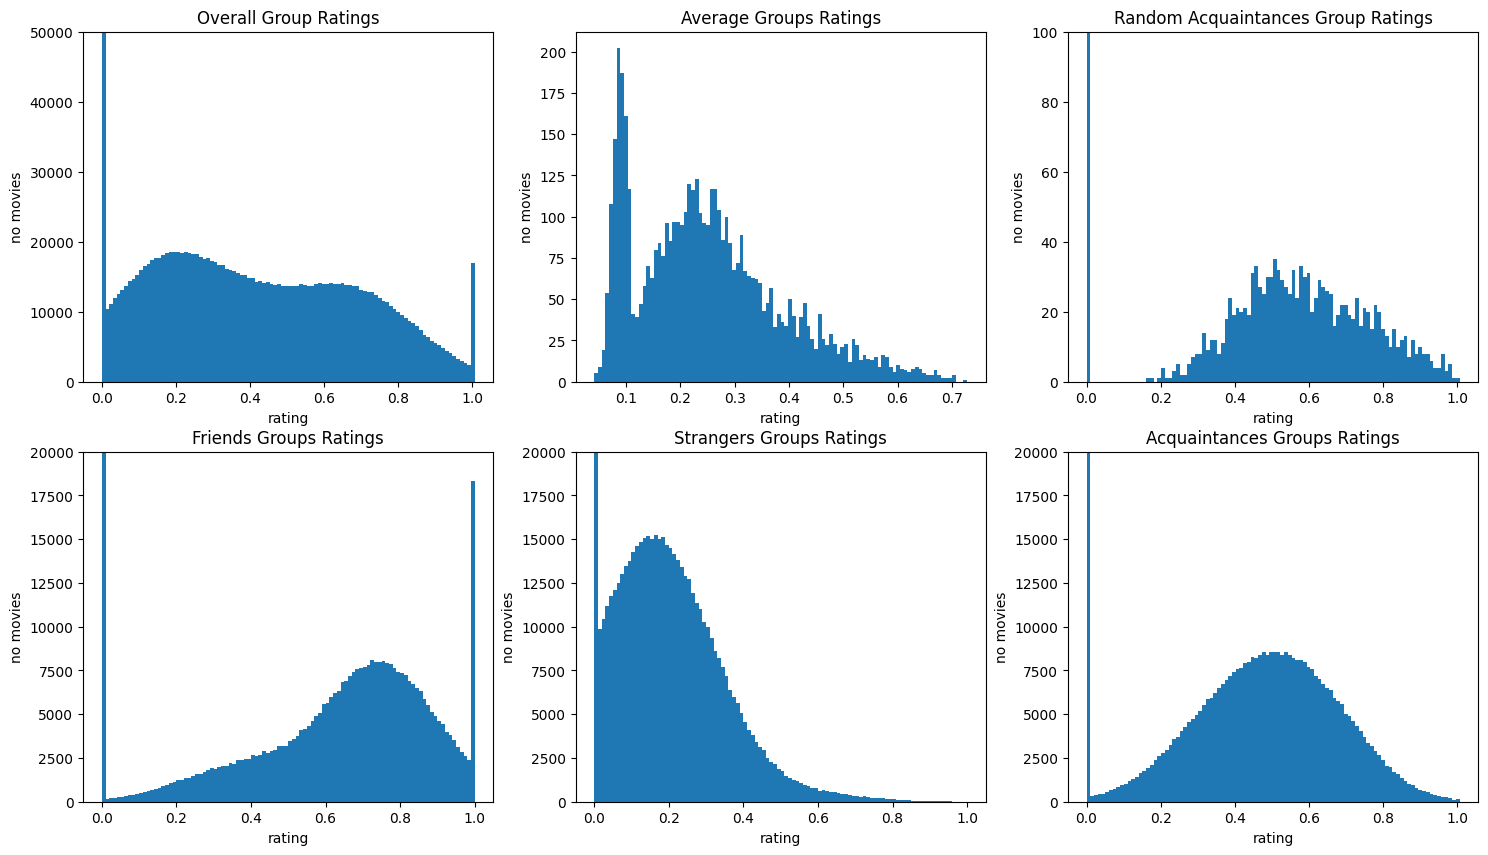

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

axs[0][0].hist(group_ratings.flatten(), bins = 100)
axs[0][1].hist(group_ratings.mean(axis=0), bins = 100)
axs[0][2].hist(group_ratings[-1], bins = 100)
axs[1][0].hist(group_ratings[:150].flatten(), bins = 100)
axs[1][1].hist(group_ratings[150:300].flatten(), bins = 100)
axs[1][2].hist(group_ratings[300:].flatten(), bins = 100)

axs[0][0].set_ylim(0, 50000)
# axs[0][1].set_ylim(0, 1000000)
axs[0][2].set_ylim(0, 100)
axs[1][0].set_ylim(0, 20000)
axs[1][1].set_ylim(0, 20000)
axs[1][2].set_ylim(0, 20000)

axs[0][0].set_title('Overall Group Ratings')
axs[0][1].set_title('Average Groups Ratings')
axs[0][2].set_title('Random Acquaintances Group Ratings')
axs[1][0].set_title('Friends Groups Ratings')
axs[1][1].set_title('Strangers Groups Ratings')
axs[1][2].set_title('Acquaintances Groups Ratings')

for i in range(2):
    for j in range(3):
        axs[i][j].set_xlabel('rating')
        axs[i][j].set_ylabel('no movies')

plt.show()

## Save raw dataset information

In [122]:
np.save('../data/synthetic_dataset/raw/user_ratings.npy', ratings)
np.save('../data/synthetic_dataset/raw/group_ratings.npy', group_ratings)

group_infos =[[idx, str(group), list(group.users)] for idx, group in enumerate(groups)]

# groups_infos
df = pd.DataFrame(data=group_infos, columns = ['group', 'type', 'users']).set_index('group')
df.to_pickle('../data/synthetic_dataset/raw/group_info.pkl')

del group_infos, df

## Split into train, validation and test data

In [123]:
import numpy as np
import pandas as pd

group_ratings = np.load('../data/synthetic_dataset/raw/group_ratings.npy')

groups, movies = np.indices(group_ratings.shape)
groups, movies = groups.flatten(), movies.flatten()
scores = np.round(group_ratings.flatten(), 2)

df = pd.DataFrame(data = {
    'entity': groups,
    'item': movies,
    'rating': scores
})

train_df = df.sample(frac=0.8)
df = df.drop(train_df.index)

val_df = df.sample(frac=0.5)
test_df = df.drop(val_df.index)

train_df.to_csv('../data/synthetic_dataset/train.csv', index=False, sep=' ')
val_df.to_csv('../data/synthetic_dataset/val.csv', index=False, sep=' ')
test_df.to_csv('../data/synthetic_dataset/test.csv', index=False, sep=' ')

del df, train_df, val_df, group_ratings, groups, movies, scores